# Balancing a Pole on a Cart Assignment 1
## Yun Kar Kit, SDAD

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

## Task 1: Development of an RL agent

### Defining State Space

For each observation, the state of the cartpole consists of cart position, cart velocity, pole angle and pole angular velocity. The cart velocity and pole angular velocity have no boundaries on the range of values they can take. To take them into account, there needs to be a boundary set for them.

The observation given provides state values as continuous floats. To make it easier to represent a finite number of states in the state space, the values of need to be discretizied into bins. An arbitrary 30 bins is set. The boundaries for cart_velocity and cart_angle are also arbitrarily set below. The format is as follows:

Range of values: <br>
-4.8 <= cart_position <= 4.8 <br>
-3.0 <= cart_velocity <= 3.0 <br>
-0.418 <= cart_angle <= 0.418<br>
-3.0 <= pole_angular_velocity <= 3.0 <br>

#### Reference to digitizing and bins: https://www.geeksforgeeks.org/binning-data-in-python-with-scipy-numpy/#binning-data-using-numpy

### Defining Actions

There are only 2 possible actions to take, move the cart left or move the cart right. Represented by 0 and 1 respectively.

Actions: {0,1}

## Setting up Q table and bins

In [4]:
# Discritize state values into 30 bins, so array of 30 x 30 x 30 x 30 x 2 is used to store values in a table Q
Q = np.zeros((30, 30, 30, 30, 2))

# Returns arrays of evenly spaced values from the boundary ends of each of the state values with 30 intervals
bins = [np.linspace(-4.8, 4.8, 31), np.linspace(-4, 4, 31), np.linspace(-0.418, 0.418, 31), np.linspace(-4, 4, 31)]

def discretize_state(observation):
  discretized_observation = []

  # Digitize puts the observations into the respective bins as defined above
  for i in range(len(observation)):
    # -1 from result of digitize as digitize starts at 1
    discretized_observation.append(np.digitize(observation[i], bins[i]) - 1)

  # return as a tuple to use for indexing
  return tuple(discretized_observation)

## Q-Learning
Using Q learning, develop the RL agent by allowing it to explore with a set probability (P), the effects of actions on different states, and populating the results into the Q table. The agent will also have (1-P) chance of choosing to exploit existing values in the Q table. This allows the agent to learn the optimal policy, such that it can take appropriate action to maximize the rewards from the cartpole problem.

## Choosing Action

In [5]:
# Arbitray probability of agent to explore random actions
P = 0.2

def action_policy(observation, Q):
  if np.random.random() < P:
    # Explore effects of a random action on current state
    return np.random.randint(2)
  else:
    # Exploiting existing values by returning the index 0 or 1 that indicates optimal action to take at given state
    return np.argmax(Q[observation])

## Training Agent
Learning rate, discount factor, and number of episodes to run are set to a constant value, to be used as parameters to train the agent. The values calculated and stored in Q are the estimated rewards for taking action chosen by the policy at a specific state.

In [6]:
# Predefined constants
learning_rate = 0.1
discount_factor = 0.99
num_episodes = 10000

for i in range(num_episodes):
  # Reset environment at the start of each episode to start a new run
  observation = env.reset()
  done = False

  while not done:
    # Use policy to pick an action based on given state
    old_observation = discretize_state(observation)
    action = action_policy(old_observation, Q)

    observation, reward, terminated, done = env.step(action)

    # Get the new state and discretize
    new_observation = discretize_state(observation)

    # Updating Q value using equation from lecture notes
    Q[old_observation[0], old_observation[1], old_observation[2], old_observation[3], action] = Q[old_observation[0], old_observation[1], old_observation[2], old_observation[3], action] + learning_rate * (reward + discount_factor * np.max(Q[new_observation]) - Q[old_observation[0], old_observation[1], old_observation[2], old_observation[3], action])

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Task 2: Demonstrate the effectiveness of the RL agent

An array episode_results is first declared to store the cumulative results of each episode.

Using a for loop, run 100 episodes, each time resetting the environment and the cumulative reward to 0 at the start of each individual episode.

While each episode has not ended, the action policy chooses an action, based on exploring or exploiting the values from Q table. The observation, reward, done, info are the results for taking the chosen action at the cartpole's current state. The reward is added to cumulative_reward, while the new observation of state of cartpole after taking the previous chosen action will be used to choose the next action using the same action policy, and this process is repeated until the episode has reached a terminal state.

After each episode has ended, the resulting cumulative_reward value is appended to episode_results list. As the for loop runs 100 times, there will be 100 cumulative_rewards in episode_results by the end of the loop.

In [7]:
episode_results = []
num_episodes = 100

for i in range(num_episodes):
  # Reset environment at the start of each episode to start a new run
  observation = env.reset()
  cumulative_reward = 0
  done = False

  while not done:
    discretized_observation = discretize_state(observation)
    action = action_policy(discretized_observation, Q)
    observation, reward, done, info = env.step(action)

    # Accumulate the rewards for each episode
    cumulative_reward += reward

  episode_results.append(cumulative_reward)

### Plotting the results
Each cumulative_reward value is plotted against its respective episode as shown in the graph above, and the average cumulative reward from 100 episodes it calculated.

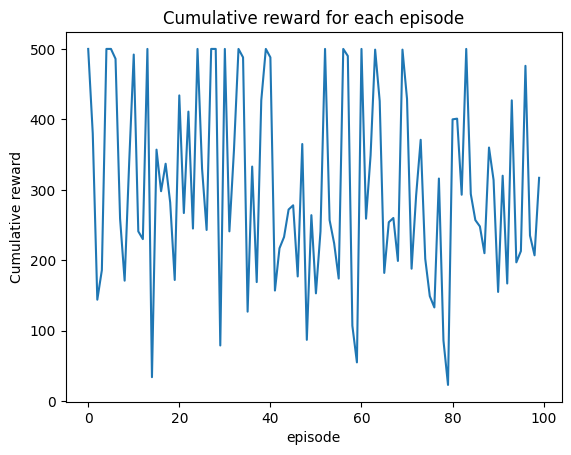

Average cumulative reward: 304.04
Is my agent good enough? True


In [8]:
# Plotting cumulative rewards for each episode on a graph
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

avg_cumulative_reward = sum(episode_results)/len(episode_results)
print("Average cumulative reward:", avg_cumulative_reward)
print("Is my agent good enough?", avg_cumulative_reward > 195)

As seen from the results, RL agent trained using Q learning technique is good enough to achieve an average cumulative score of > 195.

## Task 3: Render one episode played by the agent

Render a video to show the state of the cartpole until termination when using the Q learning agent trained.

In [19]:
# Clear the video folder to prevent wrong video from playing
!rm -rf /content/video/*

env = RecordVideo(gym.make("CartPole-v1"), "./video")

observation = env.reset()
while True:
    env.render()
    discretized_observation = discretize_state(observation)
    action = action_policy(discretized_observation, Q)
    observation, reward, done, info = env.step(action)
    if done:
      break
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
